## Оглавление
[1. Подготовка данных](#data_preparation)  
[2. Исследование задачи](#research)  
[3. Борьба с дисбалансом](#dealing_imbalance)  
[4. Тестирование модели](#test_model)  
[Вывод](#output)  

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**План работы:**  
- Подготовить данные.
- Исследовать баланс классов, обучить модель без учёта дисбаланса.
- Улучшить качество модели, учитывая дисбаланс классов. 
- Обучить разные модели и найти лучшую.
- Провести финальное тестирование.

**Описание данных**

***Признаки:***
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата  

***Целевой признак:***
- Exited — факт ухода клиента

<a id="data_preparation"></a>
# 1. Подготовка данных

#### Изучим файл с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df = df.fillna(df['Tenure'].mean().astype('int'))

In [6]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.907000,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.774873,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### Подготовим данные к обучению

Преобразуем категориальные признаки в численные, методом прямого кодирования (One-Hot Encoding, OHE):

In [10]:
df_ohe = pd.get_dummies(df, columns = ['Geography','Gender'], drop_first=True)
target = df_ohe['Exited']
features = df_ohe.drop(['Exited','RowNumber', 'CustomerId', 'Surname'], axis=1)

Разобъем данные на тестовую, валидационную, обучающую и масштабируем признаки методом **Standard Scaler**:

In [11]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345, stratify=target)


In [12]:
print(features.shape)
print(features_train.shape)
print(features_test.shape)

(10000, 11)
(8000, 11)
(2000, 11)


In [13]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train)


In [14]:
numeric = ['CreditScore', 'Age', 'Tenure','Balance', 
           'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [15]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5536,-0.143332,0.577533,-0.329033,-1.220573,0.797767,1,1,1.029613,0,1,1
8530,1.632702,-0.564119,-1.052713,0.435807,-0.916018,1,0,0.237986,0,0,0
1762,1.116413,-0.468981,-1.414553,1.245822,-0.916018,1,1,-0.686104,0,0,0
9090,1.643028,0.006707,0.032807,-1.220573,-0.916018,1,0,-0.391097,0,0,0
8777,-0.484083,-1.420358,-1.414553,1.421989,0.797767,1,0,-1.361559,0,1,1


Проведем проверку корректности разбиения данных:

In [16]:
features_valid.shape

(2000, 11)

In [17]:
features_train.shape

(6000, 11)

In [18]:
features_test.shape

(2000, 11)

In [19]:
(features_train + features_valid + features_test).shape

(10000, 11)

### Вывод

В таблице с данными 10000 строк и 14 столбцов.  

Дубликаты отсутствуют.  

Присутствуют 909 пропусков в столбце **Tenure — количество недвижимости у клиента**. Пропуск может говорить нам о том, что клиент возможно не захотел сообщить о количестве своей недвижимости, либо она отсутствует. Пропуски заполнены средним значением.


**Проведена подготовка данных к машинному обучению:**
1. Категориальные признаки преобразованы в численные, методом прямого кодирования (One-Hot Encoding, OHE). 
2. Данные разбиты на тестовую, валидационную и обучающую выборку, в соотношении 1:1:3.
3. Выполнено масштабирование признаков, методом стандартизации данных  - ***StandardScaler***. 
4. Удалены столбцы (***RowNumber, CustomerId, Surname***), которые могут повлиять на обучение модели.

Итоговые размер таблицы даных - 10000 строк, 11 столбцов.

<a id="research"></a>
# 2. Исследование задачи

Целевой признак является **категориальным и двоичным(значение 0 или 1)**, следовательно решается задача *бинарной классификации*.  
Выберем модели работающие с задачами классификации:  
1. Логистическая регрессия (*LogisticRegression*).
2. Случайный лес (*RandomForestClassifier*).

In [20]:
target_train.mean()

0.20383333333333334

Данные несбаласированны, т.к. доля значений положительного класса составляет 20%.

#### Построение моделей и подбор гиперпараметров

Для начала построим модели без учета дисбаланса классов, сравним метрики и подберем гиперпараметры моделей.

**Логистическая регрессия**

In [21]:
#Создание сетки гиперпараметров
parametrs = {'C': [0.1, 0.2, 1, 1.1, 10, 50, 100],
            "penalty":["l1","l2"]
}

In [22]:
lr = LogisticRegression(random_state=12345)
grid = GridSearchCV(lr, parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [23]:
lr = LogisticRegression(random_state=12345, C=0.1, penalty='l1')
lr.fit(features_train, target_train)
predicted_valid_lr = lr.predict(features_valid)
result_lr = lr.score(features_valid, target_valid)
f1 = f1_score(target_valid, predicted_valid_lr)
probabilities_valid = lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('Accuracy:', result_lr)
print('AUC-ROC:', auc_roc)
print('F1-score:', f1)

Accuracy: 0.819
AUC-ROC: 0.7880129744536525
F1-score: 0.311787072243346


In [24]:
#Создадим функццию печати результатов
def print_result(accuracy, auc_roc, f1_score):
    print('Accuracy:', accuracy)
    print('AUC-ROC:', auc_roc)
    print('F1-score:', f1_score)

**Случайный лес**

In [25]:
%%time
best_result = 0
for depth in range(1, 16, 1):
    for est in range(5, 50, 5):
        rfc = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        rfc.fit(features_train, target_train)
        result_rfc = rfc.score(features_valid, target_valid)
        predicted_valid = rfc.predict(features_valid)
        f1_rfc = f1_score(target_valid, predicted_valid)
        probabilities_valid = rfc.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
        if result_rfc > best_result:
            best_result = result_rfc
            best_depth = depth
            best_est = est
            best_auc_roc = auc_roc_rfc
            best_f1 = f1_rfc



print('Max_depth:', best_depth)
print('N_estimators:', best_est)
print_result(best_result, best_auc_roc, best_f1)

Max_depth: 14
N_estimators: 30
Accuracy: 0.867
AUC-ROC: 0.8477537630080003
F1-score: 0.5920245398773006
CPU times: user 26.1 s, sys: 0 ns, total: 26.1 s
Wall time: 26.3 s


#### Отдельно выведем значение метрик для каждой модели

In [26]:
none_balance = {'Balanced':'1.Несбалансированный', 
                'Accuracy':(result_lr, best_result), 
                'AUC-ROC':(auc_roc, best_auc_roc), 
                'F1-score':(f1, best_f1)}
none_balance = pd.DataFrame(none_balance, index=('Логистическая регрессия', 'Случайный лес'))
none_balance

,Balanced,Accuracy,AUC-ROC,F1-score
Логистическая регрессия,1.Несбалансированный,0.819,0.788013,0.311787
Случайный лес,1.Несбалансированный,0.867,0.847754,0.592025


### Вывод

Лучшие результаты показала модель построенная по алгортму машинного обучения ***Случайный лес (Random forest)***.  
Наиболее оптимальные гиперпараметры для модели ***Случайный лес***:
- макисимальная глубина деревьев (max_depth) - 14, 
- количество деревьев (n_estimators) - 30.

<a id="dealing_imbalance"></a>
# 3. Борьба с дисбалансом

#### Вариант 1. Увеличение выборки - техника *upsampling*

Увеличим долю значений положительного класса техникой - **upsampling**:

In [27]:
# Создадим функцию "увеличение выборки"
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return features_upsampled, target_upsampled

Применим функцию к обучающим данным и перемешаем полученные значения:

In [28]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [29]:
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

In [30]:
target_upsampled.mean()

0.5059468404178302

Мы увеличили долю значений с положительным классом до 50%.

Обучим модели по данным **features_upsampled, target_upsampled**:

In [31]:
lr_v1 = LogisticRegression(random_state=12345, C=0.1, penalty='l1')
lr_v1.fit(features_upsampled, target_upsampled)
predicted_valid_lr_v1 = lr_v1.predict(features_valid)
result_lr_v1 = lr_v1.score(features_valid, target_valid)
f1_lr_v1 = f1_score(target_valid, predicted_valid_lr_v1)
probabilities_valid = lr_v1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr_v1 = roc_auc_score(target_valid, probabilities_one_valid)
print_result(result_lr_v1, auc_roc_lr_v1, f1_lr_v1)

Accuracy: 0.714
AUC-ROC: 0.7922622159910296
F1-score: 0.5085910652920962


In [32]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

In [33]:
model_rfc_v1 = RandomForestClassifier(max_depth=14, n_estimators=30, random_state=12345)
model_rfc_v1.fit(features_upsampled, target_upsampled)
result_rfc_v1 = model_rfc_v1.score(features_valid, target_valid)
predicted_valid_rfc_v1 = model_rfc_v1.predict(features_valid)
f1_rfc_v1 = f1_score(target_valid, predicted_valid_rfc_v1)

probabilities_valid_v2 = model_rfc_v1.predict_proba(features_valid)
probabilities_one_valid_v2 = probabilities_valid_v2[:, 1]
auc_roc_rfc_v1 = roc_auc_score(target_valid, probabilities_one_valid_v2)
print_result(result_rfc_v1, auc_roc_rfc_v1, f1_rfc_v1)

Accuracy: 0.8455
AUC-ROC: 0.855014490607711
F1-score: 0.6093552465233881


In [34]:
fpr2, tpr2, thresholds2 = roc_curve(target_valid, probabilities_one_valid_v2)

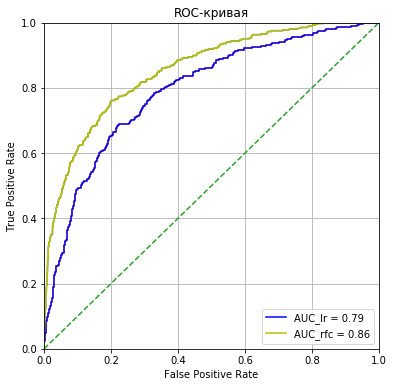

In [35]:
plt.figure(figsize=(6,6))
plt.plot(fpr2, tpr2)
plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.2f' % auc_roc_lr_v1)
plt.plot(fpr2, tpr2, 'y', label = 'AUC_rfc = %0.2f' % auc_roc_rfc_v1)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

Как и в случае обучения несбалансированной модели, лучшие результаты метрик показывает модель **Случайный лес**.  

In [36]:
upsamp_balance = {'Balanced':'2.Техника-upsampling', 
                  'Accuracy':(result_lr_v1, result_rfc_v1), 
                  'AUC-ROC':(auc_roc_lr_v1, auc_roc_rfc_v1), 
                  'F1-score':(f1_lr_v1, f1_rfc_v1)}
upsamp_balance = pd.DataFrame(upsamp_balance, index=('Логистическая регрессия', 'Случайный лес'))
upsamp_balance

,Balanced,Accuracy,AUC-ROC,F1-score
Логистическая регрессия,2.Техника-upsampling,0.7140,0.792262,0.508591
Случайный лес,2.Техника-upsampling,0.8455,0.855014,0.609355


#### Вариант 2. Взвешивание классов - class_weight

Избавимся от дисбаланса в моделях, применив в моделях значение аргумента ***class_weight***  равным ***balanced***. Рассчитаем и сравним метрики:

In [37]:
lr_v2 = LogisticRegression(random_state=12345, class_weight='balanced', C=0.1, penalty='l1')
lr_v2.fit(features_train, target_train)
predicted_valid_lr_v2 = lr_v2.predict(features_valid)
result_lr_v2 = lr_v2.score(features_valid, target_valid)
f1_lr_v2 = f1_score(target_valid, predicted_valid_lr_v2)
probabilities_valid_v2 = lr_v2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_v2[:, 1]
auc_roc_lr_v2 = roc_auc_score(target_valid, probabilities_one_valid)
print_result(result_lr_v2, auc_roc_lr_v2, f1_lr_v2)

Accuracy: 0.719
AUC-ROC: 0.7924966569034365
F1-score: 0.5087412587412588


In [38]:
model_rfc_v2 = RandomForestClassifier(max_depth=14, n_estimators=30, random_state=12345, class_weight='balanced')
model_rfc_v2.fit(features_train, target_train)
result_rfc_v2 = model_rfc_v2.score(features_valid, target_valid)
predicted_valid_rfc_v2 = model_rfc_v2.predict(features_valid)
f1_rfc_v2 = f1_score(target_valid, predicted_valid_rfc_v2)

probabilities_valid_v2 = model_rfc_v2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid_v2[:, 1]
auc_roc_rfc_v2 = roc_auc_score(target_valid, probabilities_one_valid)
print_result(result_rfc_v2, auc_roc_rfc_v2, f1_rfc_v2)

Accuracy: 0.8555
AUC-ROC: 0.8511600969228089
F1-score: 0.5853658536585367


In [39]:
cs_balance = {'Balanced':'3.Техника-class_weight',
              'Accuracy':(result_lr_v2, result_rfc_v2), 
                  'AUC-ROC':(auc_roc_lr_v2, auc_roc_rfc_v2), 
                  'F1-score':(f1_lr_v2, f1_rfc_v2)}
cs_balance= pd.DataFrame(cs_balance, index=('Логистическая регрессия', 'Случайный лес'))
cs_balance

,Balanced,Accuracy,AUC-ROC,F1-score
Логистическая регрессия,3.Техника-class_weight,0.7190,0.792497,0.508741
Случайный лес,3.Техника-class_weight,0.8555,0.851160,0.585366


Сравним результаты метрик, полученных с дисбалансом данных и без него:

In [40]:
data_balance = pd.concat([none_balance, upsamp_balance, cs_balance]).reset_index()

In [41]:
data_balance.rename(columns={'index':'Модель'}, inplace=True)

In [42]:
data_balance.pivot_table(index=['Balanced', 'Модель'])

AUC-ROC  Accuracy  F1-score
Balanced               Модель                                               
1.Несбалансированный   Логистическая регрессия  0.788013    0.8190  0.311787
                       Случайный лес            0.847754    0.8670  0.592025
2.Техника-upsampling   Логистическая регрессия  0.792262    0.7140  0.508591
                       Случайный лес            0.855014    0.8455  0.609355
3.Техника-class_weight Логистическая регрессия  0.792497    0.7190  0.508741
                       Случайный лес            0.851160    0.8555  0.585366

При обучении моделей сбалансированных моделей, можно заметить:  
- метрика Accuracy уменьшилась для всех моделей,
- метрика AUC_ROC практически не изменилась,
- метрика F1-score увеличилась для всех моделей.  

Наибольший прирост метрики F1-score мы наблюдаем для логистической регрессии.  

Модель **Случайный лес** показывает лучшие результаты, будем использовать ее в дальнейшем исследовании.

<a id="test_model"></a>
# 4. Тестирование модели

Сгруппируем тренировочную и валидационную выборки перед финальным тестированием:

In [43]:
final_features = pd.concat([features_train, features_valid])

In [44]:
final_target = pd.concat([target_train, target_valid])

In [45]:
final_target.mean()

0.20375

In [46]:
final_features.shape

(8000, 11)

Избавимся от дисбаланса и обучим модель:

In [47]:
features_upsampled_mf, target_upsampled_mf = upsample(final_features, final_target, 4)

In [48]:
model_final = RandomForestClassifier(max_depth=14, n_estimators=30, random_state=12345)
model_final.fit(features_upsampled_mf, target_upsampled_mf)
predicted_mf = model_final.predict(features_upsampled_mf)
result_mf = model_final.score(features_upsampled_mf, target_upsampled_mf)
f1_mf = f1_score(target_upsampled_mf, predicted_mf)

probabilities_valid_mf = model_final.predict_proba(features_upsampled_mf)
probabilities_one_valid = probabilities_valid_mf[:, 1]
auc_roc_mf = roc_auc_score(target_upsampled_mf, probabilities_one_valid)
print_result(result_mf, auc_roc_mf, f1_mf)

Accuracy: 0.9881303335919317
AUC-ROC: 0.9995817241478941
F1-score: 0.9883535053665221


Проведем тестирование модели **Случайного леса** на тестовой выборке:

In [49]:
predicted_test = model_final.predict(features_test)
f1_test = f1_score(target_test, predicted_test)
result_predicted_test = accuracy_score(target_test, predicted_test)
probabilities_valid = model_final.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_valid)
print_result(result_predicted_test, auc_roc_test, f1_test)

Accuracy: 0.84
AUC-ROC: 0.8592012659809272
F1-score: 0.6039603960396039


***Построим график ROC-кривой:***

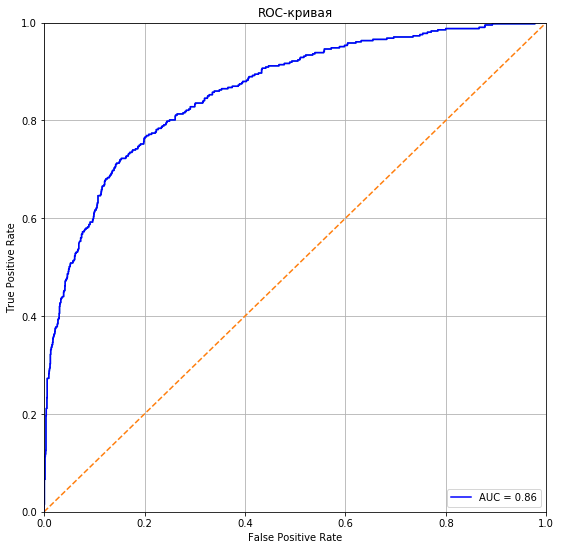

In [50]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc_test)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

ROC-кривая показывает нам, что качество модели для бинарной классификации значительно выше чем у случайной модели.  
**AUC = 0,86**  

По ROC-кривой, мы можем подобрать необходимую точность, исходя из порогов и поставленной бизнес-задачи.

In [51]:
X = target
y = model_final.predict(features)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy="most_frequent")
predict = dummy_clf.predict(X)
result_mf = dummy_clf.score(X, y)
f1_dum = f1_score(X, predict)
probabilities_valid_dum = dummy_clf.predict_proba(y)
probabilities_one_valid = probabilities_valid_dum[:, 1]
auc_roc_dum = roc_auc_score(X, probabilities_one_valid)
print_result(result_mf, auc_roc_dum, f1_dum)

Accuracy: 0.6027
AUC-ROC: 0.5
F1-score: 0.0


<a id="output"></a>
# Вывод

В таблице с данными 10000 строк и 14 столбцов.  

Дубликаты отсутствуют.  

Присутствуют 909 пропусков в столбце **Tenure — количество недвижимости у клиента**.  
Пропуски заполнены средним значением.

Проведена подготовка данных к машинному обучению:
1. Применен метод прямого кодирования (One-Hot Encoding, OHE). 
2. Данные разбиты на тестовую, валидационную и обучающую выборку, в соотношении 1:1:3.
3. Выполнено масштабирование признаков, методом стандартизации данных - ***StandardScaler***. 
4. Удалены столбцы (***RowNumber, CustomerId, Surname***), которые могут повлиять на обучение модели.

Итоговые размер таблицы даных - **10000 строк, 11 столбцов.**  

Исследование проведено для двух видов моделей:
1. Логистическая регрессия (*LogisticRegression*).
2. Случайный лес (*RandomForestClassifier*).  

Данные несбаласированны, доля значений положительного класса составляет **20%**.  

Лучшие результаты метрик показала модель построенная по алгортму машинного обучения ***Случайный лес (Random forest)***.  

Оптимальные гиперпараметры ***Случайный лес***:
- макисимальная глубина деревьев **(max_depth) - 14**, 
- количество деревьев **(n_estimators) - 30**.  

Изучены два вида борьбы с дисбалансом:
1. Увеличение выборки - техника upsampling.
2. Взвешивание классов - class_weight.

При обучении сбалансированных моделей, выявлено:  
- метрика Accuracy уменьшилась для всех моделей,
- метрика AUC_ROC практически не изменилась,
- метрика F1-score увеличилась для всех моделей.  

Оба варианта борьбы с дисбалансом показывают отличные результаты на тестовой выборке.  

**Удалось достичь наилучших значений метрик на тестовой выборке:**  
- **Accuracy: 0.84;**
- **AUC-ROC: 0.860;**
- **F1-score: 0.603.**